In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from datetime import datetime

In [7]:
from pyspark import SparkContext
sc = SparkContext('local[*]','temp')

22/07/21 23:23:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [8]:
from pyspark.sql import SQLContext
sqlContext=SQLContext(sc)

In [127]:
rdd=sc.binaryRecords('/media/benjamin/Data/Chicago_Transit/TNP/201911TNP.dat,/media/benjamin/Data/Chicago_Transit/TNP201912TNP.dat',96)

In [110]:
dt=np.dtype([('id',np.ulonglong),('start year',np.short),('start month',np.byte),('start day',np.byte),('start hour',np.byte),('start minute',np.byte),('end year',np.short),('end month',np.byte),('end day',np.byte),('end hour',np.byte),('end minute',np.byte),('trip seconds',np.uint32),('trip miles',np.single),('pickup census tract',np.ulonglong),('dropoff census tract',np.ulonglong),('pickup community area',np.byte),('dropoff community area',np.byte),('fare',np.single),('tip',np.single),('addcharge',np.single),('trip total',np.single),('st auth',np.byte),('pool',np.byte),('pickup lat',np.double),('pickup lon',np.double),('dropoff lat',np.double),('dropoff lon',np.double)])

In [96]:
rdd.count()

9305447

In [11]:
def read_array(x):
    array=np.frombuffer(bytes(x),dtype=dt)
    #array=array.newbyteorder().byteswap() # big Endian
    return array.tolist()[0]

In [111]:
out=rdd.map(read_array)

In [112]:
zz=out.toDF(['id','start year','start month','start day','start hour','start minute','end year','end month','end day','end hour','end minute','trip seconds','trip miles','pickup census tract','dropoff census tract','pickup community area','dropoff community area','fare','tip','addcharge','trip total','st auth','pool','pickup lat','pickup lon','dropoff lat','dropoff lon'])

In [242]:
to_jday = F.udf(lambda row: pd.Timestamp(row[0],row[1],row[2],row[3]).to_julian_date())

In [250]:
to_dt = F.udf(lambda row: datetime(row[0],row[1],row[2],row[3]))

In [113]:
zz.withColumn('loop to ohare',(zz['dropoff community area']==74) & (zz['pickup community area']==32))

DataFrame[id: bigint, start year: bigint, start month: bigint, start day: bigint, start hour: bigint, start minute: bigint, end year: bigint, end month: bigint, end day: bigint, end hour: bigint, end minute: bigint, trip seconds: bigint, trip miles: double, pickup census tract: bigint, dropoff census tract: bigint, pickup community area: bigint, dropoff community area: bigint, fare: double, tip: double, addcharge: double, trip total: double, st auth: bigint, pool: bigint, pickup lat: double, pickup lon: double, dropoff lat: double, dropoff lon: double, loop to ohare: boolean]

In [246]:
repeater = F.udf(lambda x: x[0]*365.25*24+(x[1]-1)*30.5*24+(x[2]-1)*24+x[3])

In [251]:
zzt=zz.withColumn('repeated',to_dt(F.struct([zz[x] for x in zz.columns])))

In [252]:
zzt.show()

22/07/16 16:31:44 ERROR Executor: Exception in task 0.0 in stage 61.0 (TID 3812)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 211, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 132, in dump_stream
    for obj in iterator:
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 200, in _batched
   

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 211, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 132, in dump_stream
    for obj in iterator:
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 200, in _batched
    for item in iterator:
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in mapper
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in <genexpr>
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 85, in <lambda>
    return lambda *a: f(*a)
  File "/home/benjamin/anaconda3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_9512/3604848884.py", line 1, in <lambda>
ValueError: year 41462311 is out of range


In [209]:
bd=F.struct([zz[x] for x in zz.columns])

In [218]:
p=repeater(bd)

In [114]:
ab=zz.groupby(['start year','start month','start day','start hour','pickup community area']).count()

In [115]:
ab32=ab.where(ab['pickup community area']==32)

In [116]:
zb=ab32.sort(['start year','start month','start day','start hour']).toPandas()

In [117]:
zb.tail(50)

,start year,start month,start day,start hour,pickup community area,count
26062,2021,10,29,22,32,13
26063,2021,10,29,23,32,12
26064,2021,10,30,0,32,11
26065,2021,10,30,1,32,7
26066,2021,10,30,2,32,4
26067,2021,10,30,3,32,3
26068,2021,10,30,4,32,2
26069,2021,10,30,5,32,5
26070,2021,10,30,6,32,1
26071,2021,10,30,7,32,6


In [119]:
fft=np.fft.fft(zb['count']-np.mean(zb['count']))

In [120]:
fft.size

26112

In [35]:
15062/24

627.5833333333334

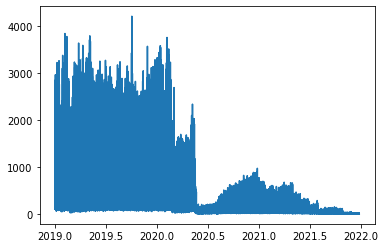

In [121]:
plt.plot(np.arange(0,26112)/24./365.+2019,zb['count'])


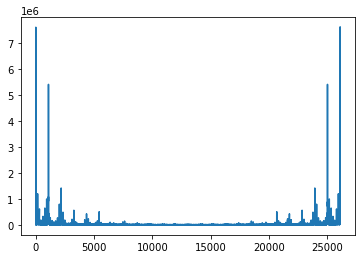

In [122]:
plt.plot(np.arange(0,26112),np.abs(fft))

In [148]:
ts=pd.Timestamp(2008,12,11,16,4)

In [130]:
ts.to_julian_date()

2454812.1694444446

In [ ]:
from pyspark.sql.functions import udf, struct
from pyspark.sql.types import IntegerType

df = sqlContext.createDataFrame([(None, None), (1, None), (None, 2)], ("a", "b"))

count_empty_columns = udf(lambda row: len([x for x in row if x == None]), IntegerType())

new_df = df.withColumn("null_count", count_empty_columns(struct([df[x] for x in df.columns])))

new_df.show()

In [ ]:
yrs=[2019,2020]

In [ ]:
yrmo=[(yr,mo)]